In [1]:
import os
import numpy as np
import pandas as pd

import scanpy as sc
import decoupler as dc
import liana as li
import squidpy as sq

import muon as mu

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
from scipy.sparse import csr_matrix

In [3]:
data_dir = os.path.join('..', '..', 'data', 'heart_visium')

In [4]:
dataset_names = [f for f in os.listdir(data_dir) if f.endswith('.h5ad')]

In [5]:
metadata = pd.read_csv(os.path.join("..", "spot_calling", "visium_meta.csv"))

In [6]:
# get IZ samples
metadata = metadata[metadata['major_labl']=='IZ']

Pick this: 	Visium_7_CK285

In [7]:
metadata

slide_name patient patient_region_id patient_group major_labl batch  \
1     AKK002_157779      P3             IZ_P3       group_2         IZ   10X   
4     AKK003_157775      P2          IZ/BZ_P2       group_2         IZ   10X   
10  Visium_11_CK289     P13         GT/IZ_P13       group_2         IZ   ACH   
14  Visium_15_CK293     P16            IZ_P16       group_2         IZ   ACH   
17  Visium_18_CK296     P15         GT/IZ_P15       group_2         IZ   ACH   
18  Visium_19_CK297      P9     GT/IZ_P9_rep2       group_2         IZ   ACH   
20  Visium_20_CK298     P15            IZ_P15       group_2         IZ   ACH   
25   Visium_7_CK285     P10            IZ_P10       group_2         IZ   ACH   
27   Visium_9_CK287      P9          GT/IZ_P9       group_2         IZ   ACH   

   hca_sample_id  
1        10X0017  
4        10X0018  
10       ACH0010  
14       ACH0016  
17       ACH0011  
18       ACH0013  
20       ACH0015  
25       ACH0014  
27       ACH0012

In [8]:
# load collecTRI regulons
net = dc.get_dorothea(organism='human')

In [9]:
sc.set_figure_params(fontsize=16, figsize=(8, 8), frameon=False)

Read in H loadings from NMF

In [10]:
selected_factor = 'Factor2'

In [11]:
lr_loadings = pd.read_csv(os.path.join("results", "lr_loadings.csv"), index_col=0)

In [12]:
lr_loadings.sort_values(selected_factor, ascending=False).head(10)

Factor1   Factor2   Factor3
SPP1^ITGA5_ITGB1     0.161688  3.027700  0.051063
SPP1^ITGAV_ITGB1     0.468820  2.857558  0.205884
SPP1^CD44            0.506221  2.813919  0.131619
TNC^ITGA5            0.162581  2.728338  0.226909
NAMPT^ITGA5_ITGB1    0.405400  2.668208  0.909761
PLAU^ITGB1           0.358635  2.449375  0.123887
TNC^ITGA7            0.201845  2.394695  0.424595
ANGPTL4^ITGA5_ITGB1  0.360589  2.378258  0.000000
SPP1^ITGAV_ITGB5     0.792621  2.353432  0.055789
CALR^ITGA3           0.000000  2.278533  0.000000

<AxesSubplot:>

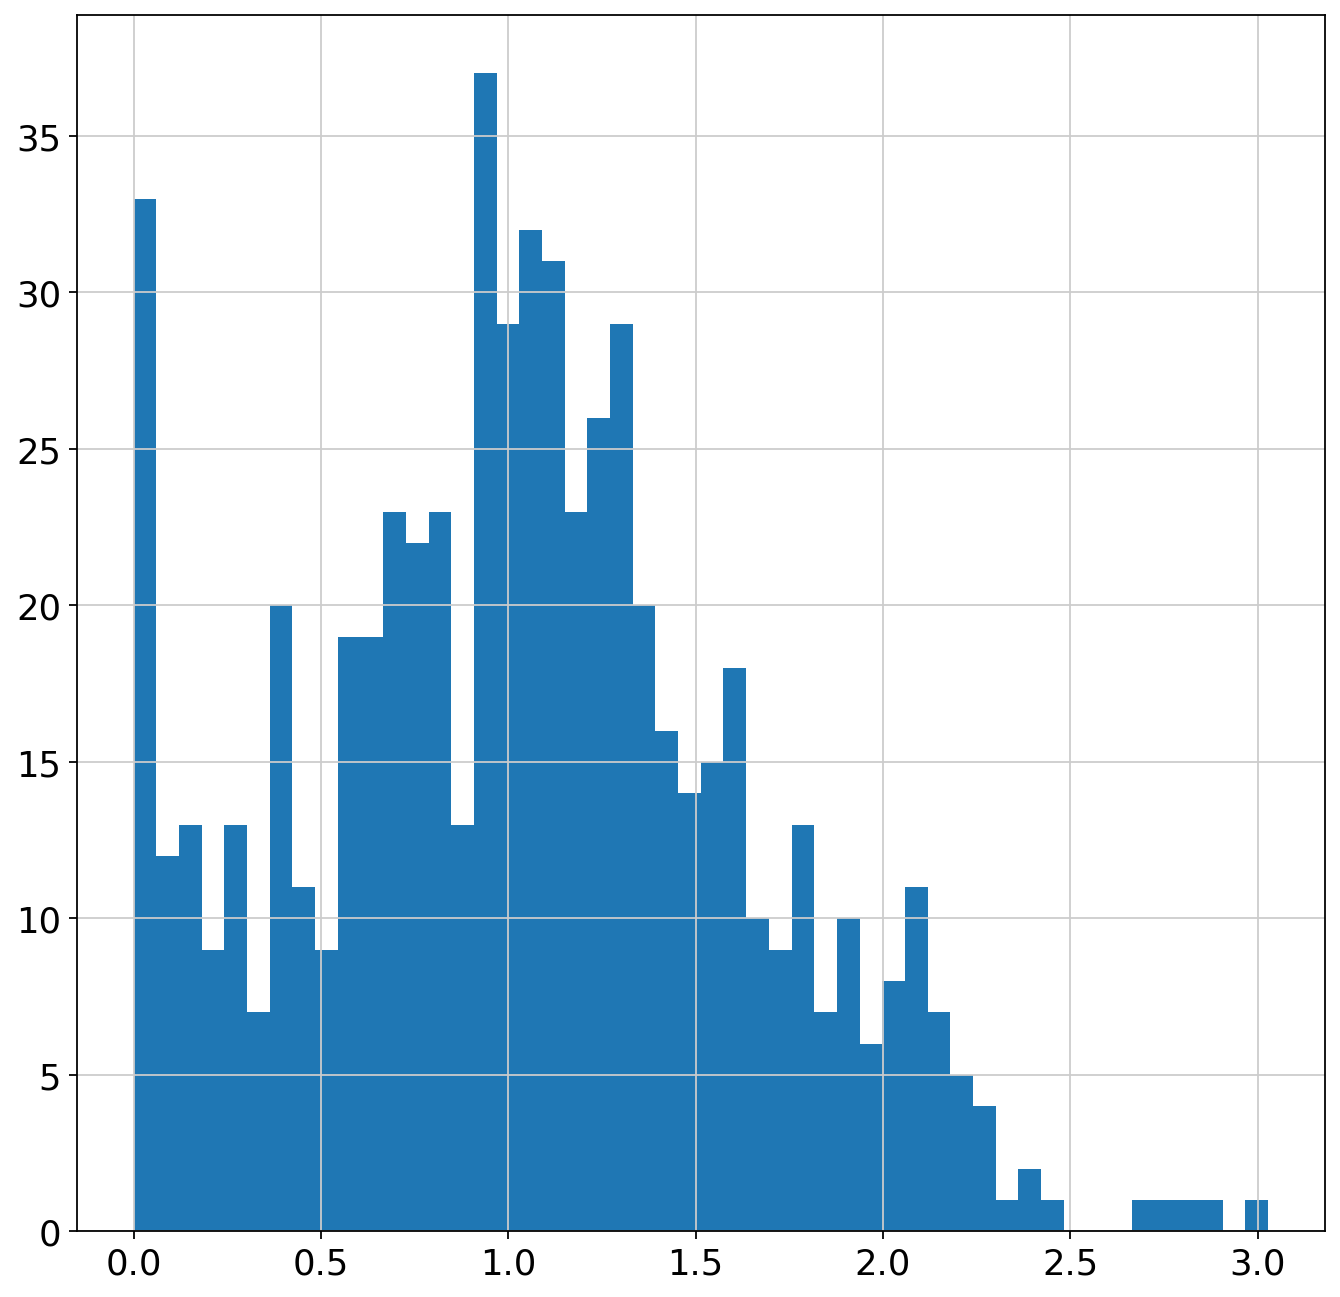

In [13]:
# histogram
lr_loadings[selected_factor].hist(bins=50, figsize=(10, 10))

In [14]:
top_features = lr_loadings.sort_values(selected_factor, ascending=False).head(20).index

In [15]:
top_features

Index(['SPP1^ITGA5_ITGB1', 'SPP1^ITGAV_ITGB1', 'SPP1^CD44', 'TNC^ITGA5',
       'NAMPT^ITGA5_ITGB1', 'PLAU^ITGB1', 'TNC^ITGA7', 'ANGPTL4^ITGA5_ITGB1',
       'SPP1^ITGAV_ITGB5', 'CALR^ITGA3', 'PLAU^ITGA5', 'FN1^ITGA3_ITGB1',
       'COL4A1^ITGA3_ITGB1', 'COL6A2^ITGA3_ITGB1', 'LGALS1^PTPRC',
       'COL4A2^ITGA3_ITGB1', 'COL6A1^ITGA3_ITGB1', 'COL1A2^ITGA3_ITGB1',
       'PKM^CD44', 'FN1^PLAUR'],
      dtype='object')

Load files, join to MuData

In [16]:
mdatas = {}
target_metrics = {}
interactions = {}

for sample in metadata['slide_name']:
    print(f"Now running: {sample}")
    
    lr = sc.read_h5ad(os.path.join('results', 'lr', sample + '.h5ad'))
    msk = lr.var.index[lr.var_names.isin(top_features)]
    lr = lr[:, msk]
    
    # run TF enrichment
    adata = sc.read_h5ad(os.path.join('results', 'processed', sample + '.h5ad'))
    
    # NOTE: here we exclude the diagonal (given we want to predict the intra with surrounding spots)
    li.ut.spatial_neighbors(adata, bandwidth=150, set_diag=False, cutoff=0.05)
    
    dc.run_ulm(adata,
               net,
               source="source", target="target",
               use_raw=False, min_n=5)
    tf = li.ut.obsm_to_adata(adata, 'ulm_estimate')
    # exract compositions
    comp = li.ut.obsm_to_adata(adata, 'compositions')
    comp = comp[:, comp.var.index!='prolif']
    
    # Build misty views and run MISTy
    mdata = mu.MuData({"intra": lr.copy(), "comp":comp.copy(), "tf":tf.copy()})
    mu.pp.intersect_obs(mdata)
    misty = li.mt.MistyData(mdata)
    misty(model='linear', verbose=True, bypass_intra=True)
    
    target_metrics[sample] = misty.uns['target_metrics']
    interactions[sample] = misty.uns['interactions']
    
    mdatas[sample] = mdata

Now running: AKK002_157779


Now learning: TNC^ITGA7: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]          


Now running: AKK003_157775


Now learning: TNC^ITGA7: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]          


Now running: Visium_11_CK289


Now learning: TNC^ITGA7: 100%|██████████| 13/13 [00:17<00:00,  1.32s/it]         


Now running: Visium_15_CK293


Now learning: TNC^ITGA7: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]          


Now running: Visium_18_CK296


Now learning: TNC^ITGA7: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]          


Now running: Visium_19_CK297


Now learning: TNC^ITGA7: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]          


Now running: Visium_20_CK298


Now learning: TNC^ITGA7: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]          


Now running: Visium_7_CK285


Now learning: TNC^ITGA7: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]         


Now running: Visium_9_CK287


Now learning: TNC^ITGA7: 100%|██████████| 18/18 [00:17<00:00,  1.04it/s]          


In [17]:
targets = pd.concat(target_metrics).reset_index().rename(columns={'level_0':'sample'}).drop(columns='level_1').copy()
targets.to_csv(os.path.join("results", "misty_targets.csv"))

In [18]:
ints = pd.concat(interactions).reset_index().rename(columns={'level_0':'sample'}).drop(columns='level_1').copy()
ints.to_csv(os.path.join("results", "misty_interactions.csv"))

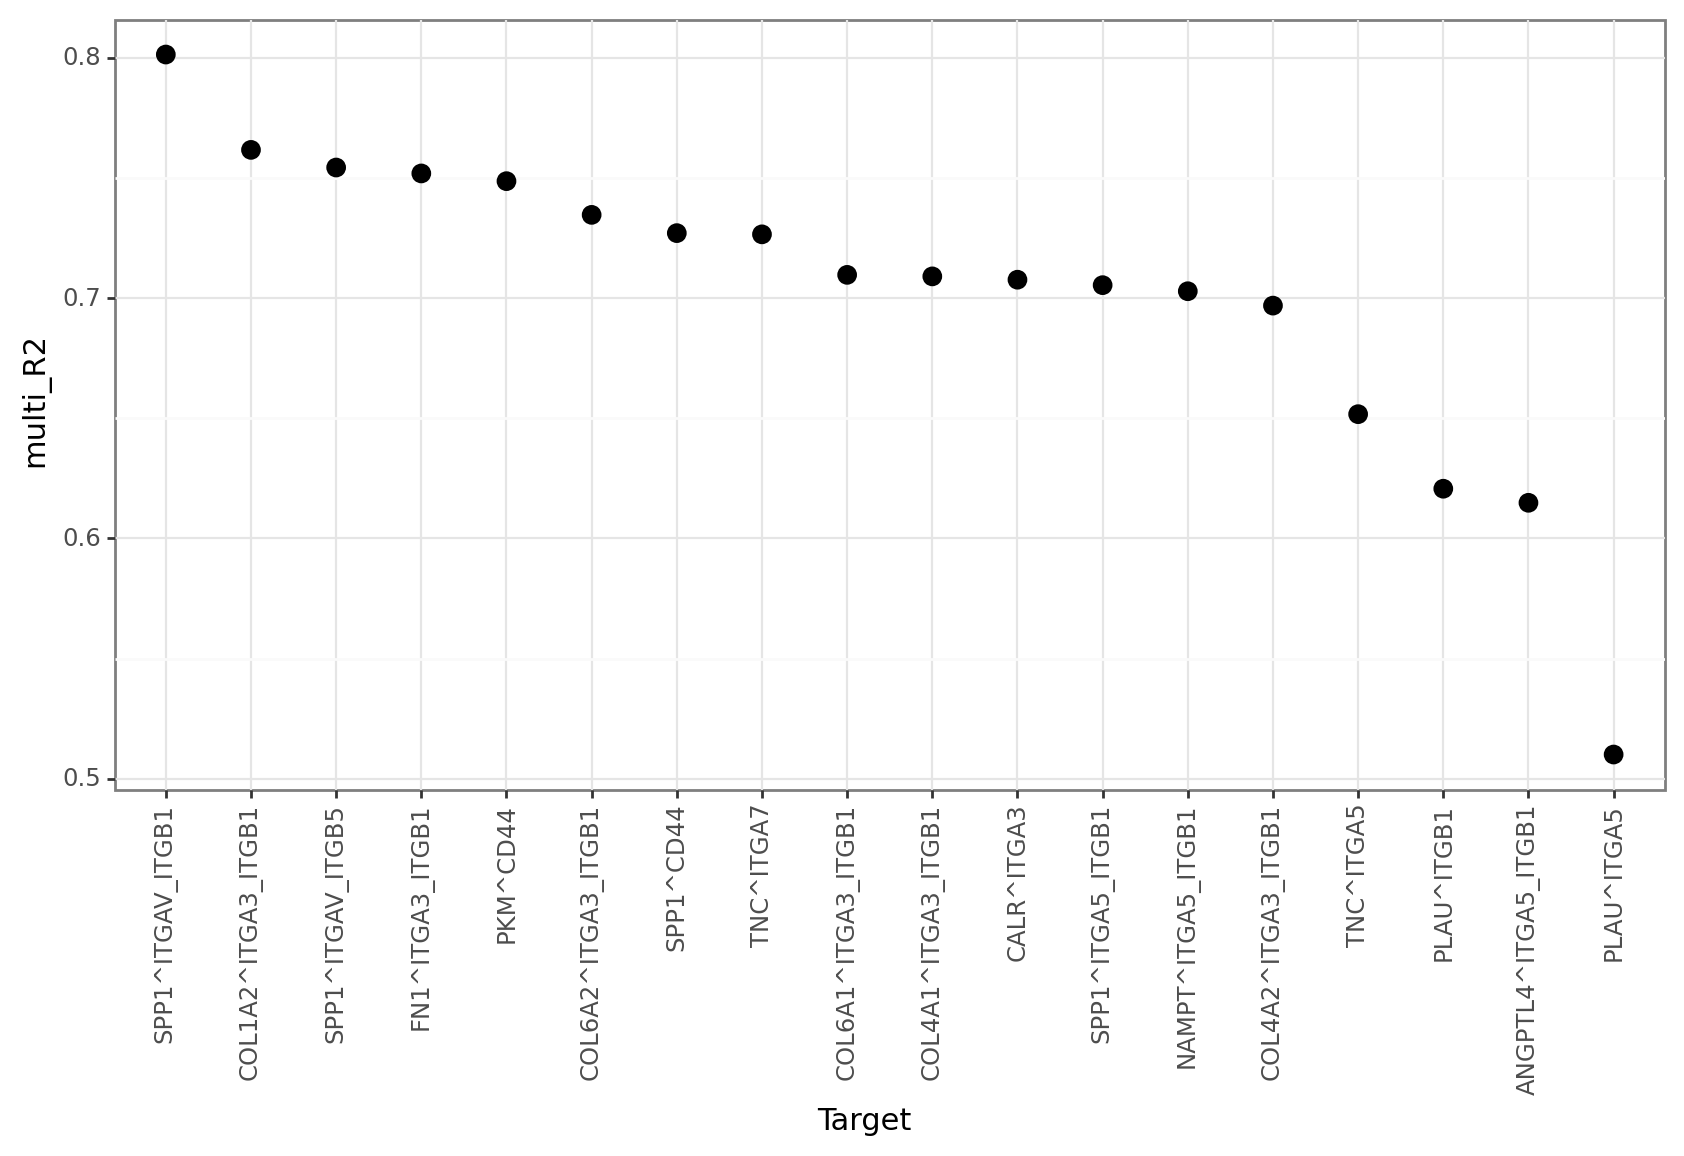

<ggplot: (8777079842940)>

In [19]:
li.pl.target_metrics(misty, stat='multi_R2', return_fig=True, figure_size=(10, 5))

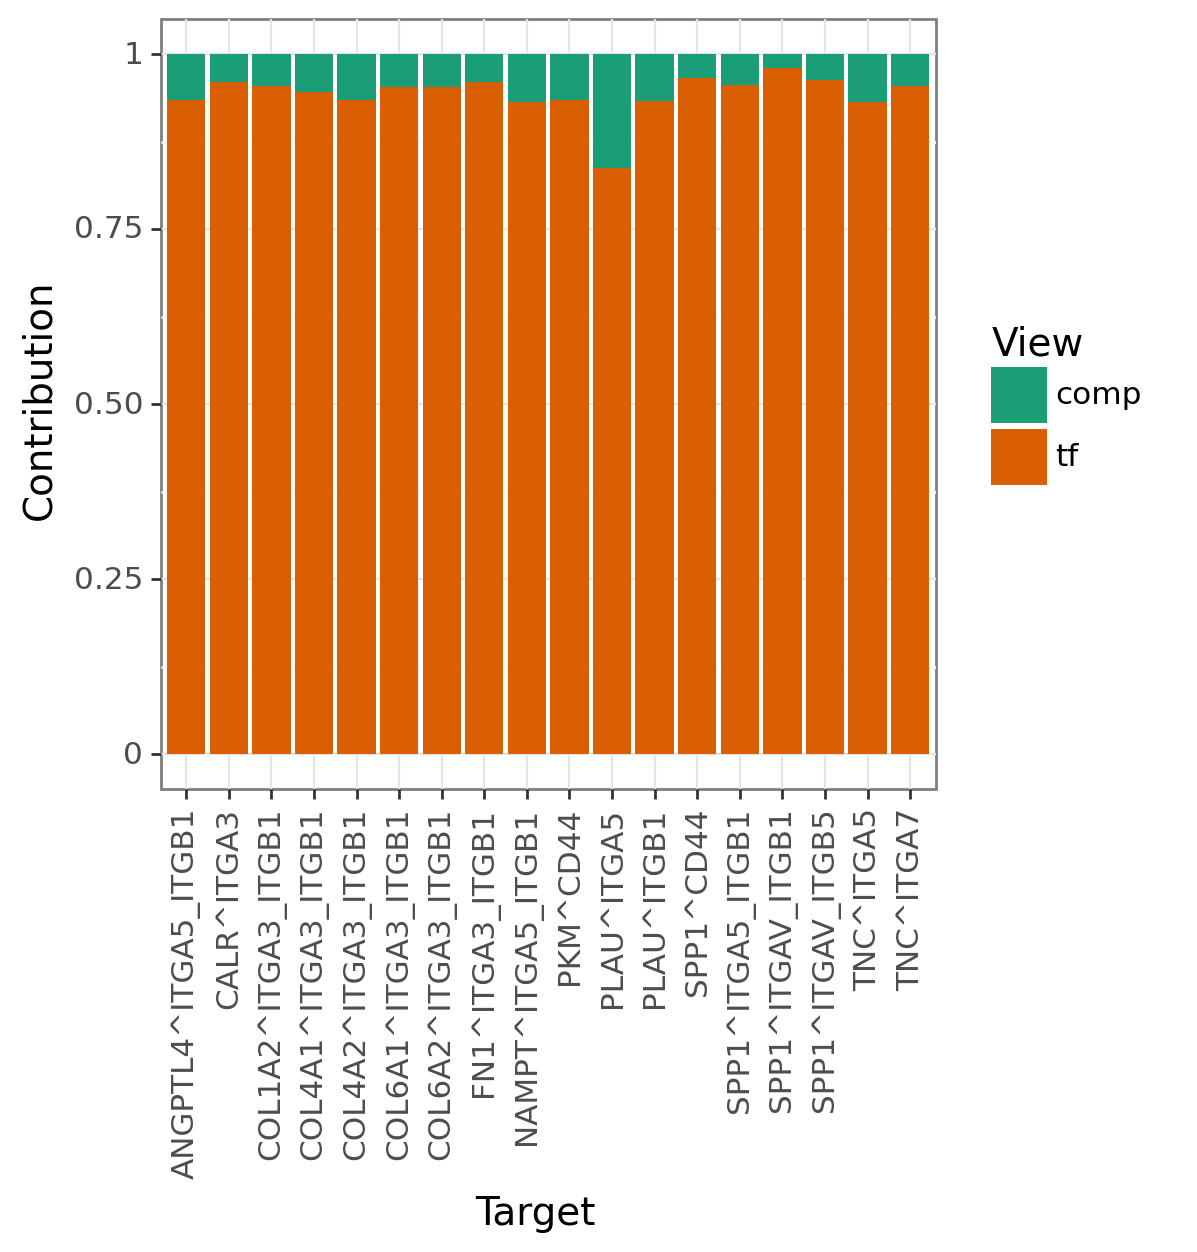

<ggplot: (8777079499584)>

In [20]:
li.pl.contributions(misty, return_fig=True, figure_size=(5, 5))

In [21]:
interactions = misty.uns['interactions'].copy()

In [22]:
interactions[interactions['view']=='tf'].sort_values("importances", ascending=False, key=lambda x: abs(x)).head(15)

target predictor view  importances
9516     NAMPT^ITGA5_ITGB1      PAX6   tf    14.282640
5975              PKM^CD44    TCF7L2   tf    12.885062
9852      SPP1^ITGAV_ITGB1     SMAD1   tf    11.182970
8949      SPP1^ITGA5_ITGB1     SMAD1   tf     9.925444
5638             SPP1^CD44     SMAD1   tf     9.835650
8900      SPP1^ITGA5_ITGB1     NR1H2   tf    -9.561549
8053    COL4A2^ITGA3_ITGB1     SOX11   tf    -9.497862
9772      SPP1^ITGAV_ITGB1       MAX   tf     9.460252
9215   ANGPTL4^ITGA5_ITGB1      PAX6   tf     9.347988
6110            PLAU^ITGB1     GATA2   tf     9.311564
7840    COL4A2^ITGA3_ITGB1      ARNT   tf    -9.307035
5972              PKM^CD44      TCF4   tf     9.282116
10427     SPP1^ITGAV_ITGB5    POU2F2   tf     9.279495
6650            PLAU^ITGA5   BHLHE40   tf     9.062104
5689             SPP1^CD44      USF1   tf    -8.927512

Plot sample averages

In [23]:
import plotnine as p9

In [24]:
ints = pd.read_csv(os.path.join("results", "misty_interactions.csv"), index_col=0)
targets = pd.read_csv(os.path.join("results", "misty_targets.csv"), index_col=0)

Contributions

In [25]:
contributions = targets[['target', 'tf', 'comp', 'sample']].melt(id_vars=['target', 'sample'], var_name='view', value_name='contribution').copy()

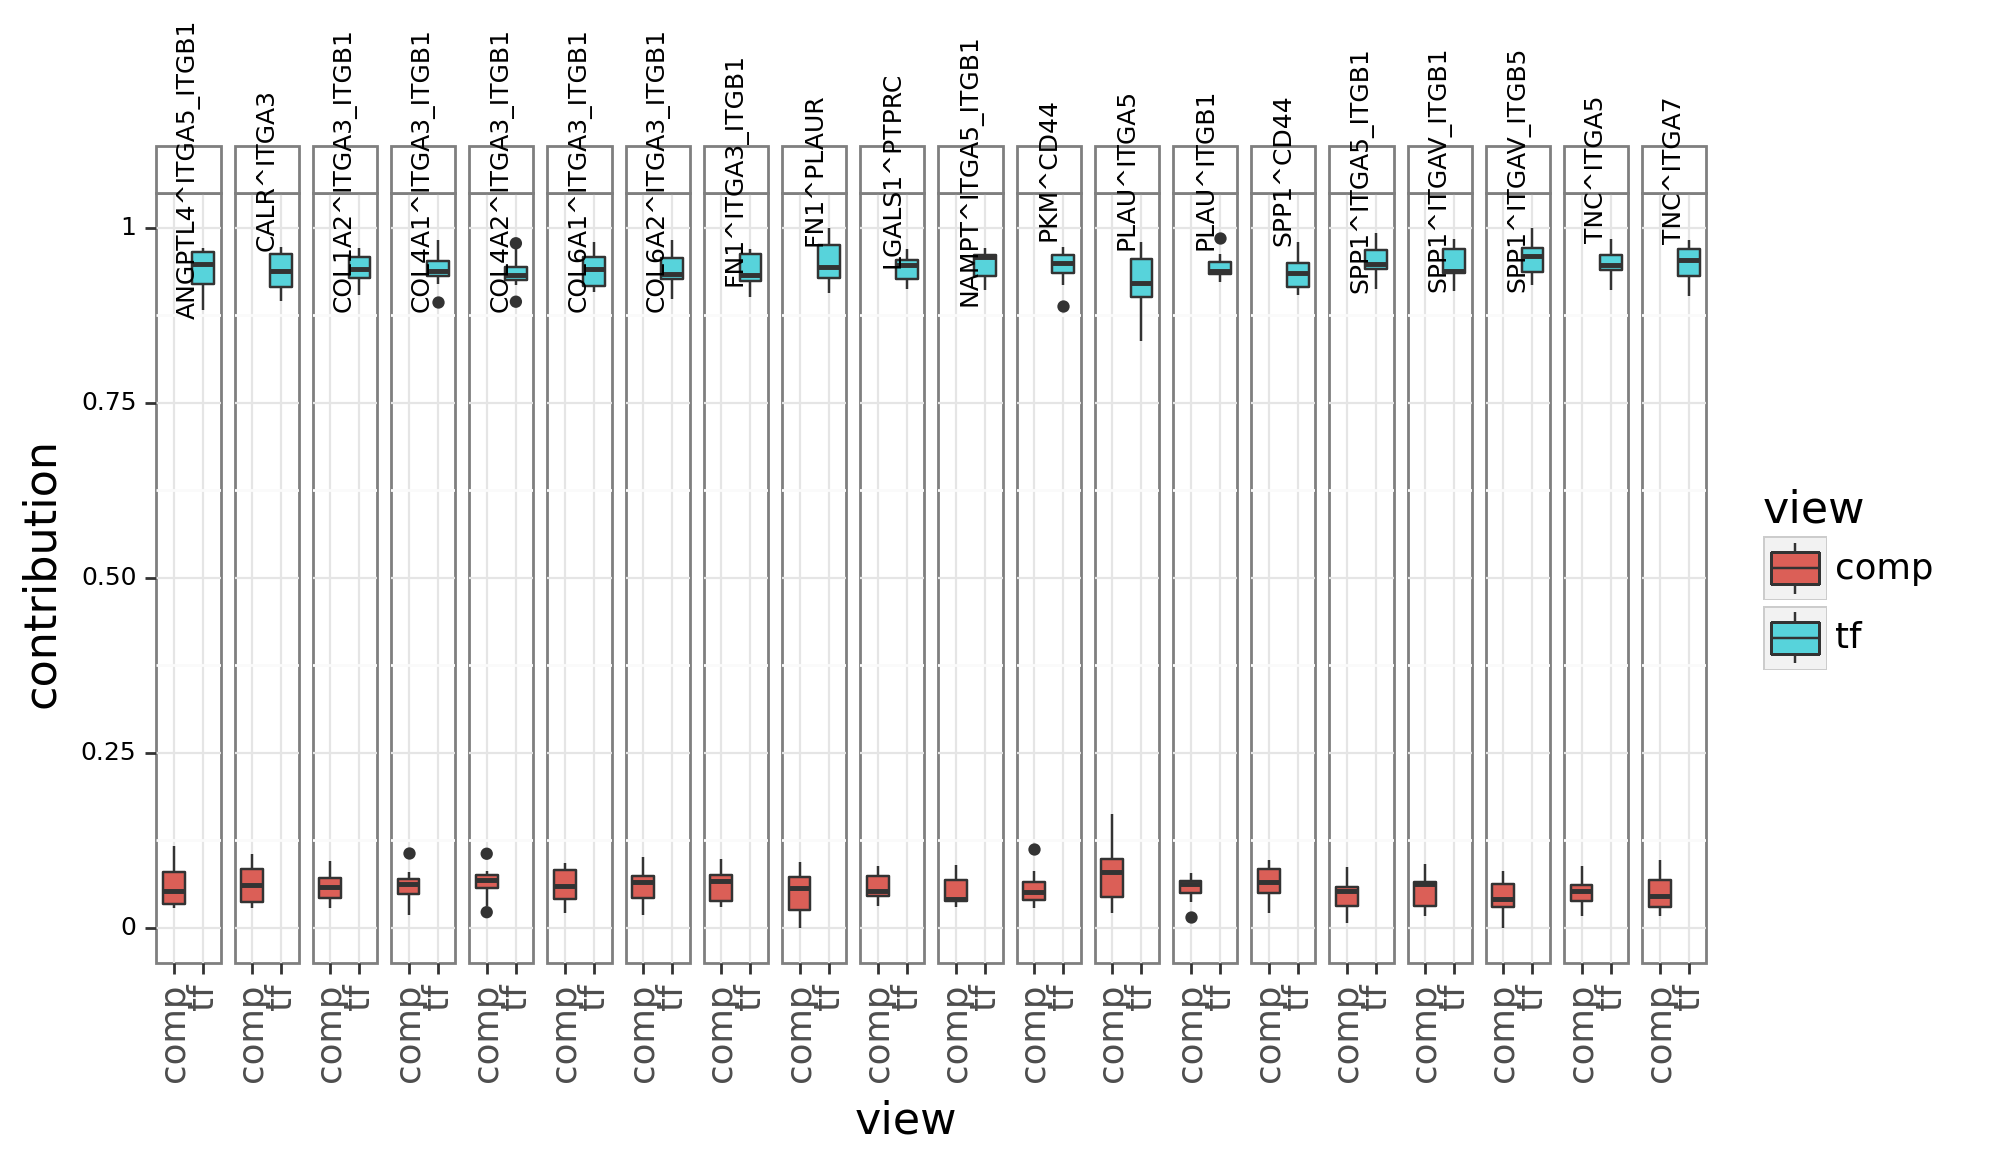

<ggplot: (8777115298789)>

In [26]:
### boxplot, ~target, x=view, y=contribution

(
    p9.ggplot(contributions, p9.aes(x='view', y='contribution', fill='view')) +
    p9.geom_boxplot() +
    p9.facet_wrap('~ target', nrow=1) +
    p9.theme_bw(base_size=16) +
    p9.theme(axis_text_x=p9.element_text(rotation=90),
             figure_size=(10, 5),
             strip_background=p9.element_rect(fill="white"),
             strip_text=p9.element_text(size=9, colour="black", rotation=90),
             axis_text_y=p9.element_text(size=9, colour="black"),
             )
    # flip coord
)


#### R2 multi

In [27]:
targets

sample             target  intra_R2  multi_R2   gain_R2  \
0     AKK002_157779       LGALS1^PTPRC         0  0.814461  0.814461   
1     AKK002_157779          SPP1^CD44         0  0.888444  0.888444   
2     AKK002_157779           PKM^CD44         0  0.916197  0.916197   
3     AKK002_157779         PLAU^ITGB1         0  0.891445  0.891445   
4     AKK002_157779          TNC^ITGA5         0  0.911278  0.911278   
..              ...                ...       ...       ...       ...   
165  Visium_9_CK287  NAMPT^ITGA5_ITGB1         0  0.702893  0.702893   
166  Visium_9_CK287   SPP1^ITGAV_ITGB1         0  0.801419  0.801419   
167  Visium_9_CK287         CALR^ITGA3         0  0.707689  0.707689   
168  Visium_9_CK287   SPP1^ITGAV_ITGB5         0  0.754386  0.754386   
169  Visium_9_CK287          TNC^ITGA7         0  0.726572  0.726572   

         comp        tf  
0    0.030327  0.969673  
1    0.063473  0.936527  
2    0.033124  0.966876  
3    0.049174  0.950826  
4    0.032208  0.967792  
..        ...       ...  
165  0.068413  0.931587  
166  0.019651  0.980349  
167  0.039564  0.960436  
168  0.036826  0.963174  
169  0.045613  0.954387  

[170 rows x 7 columns]

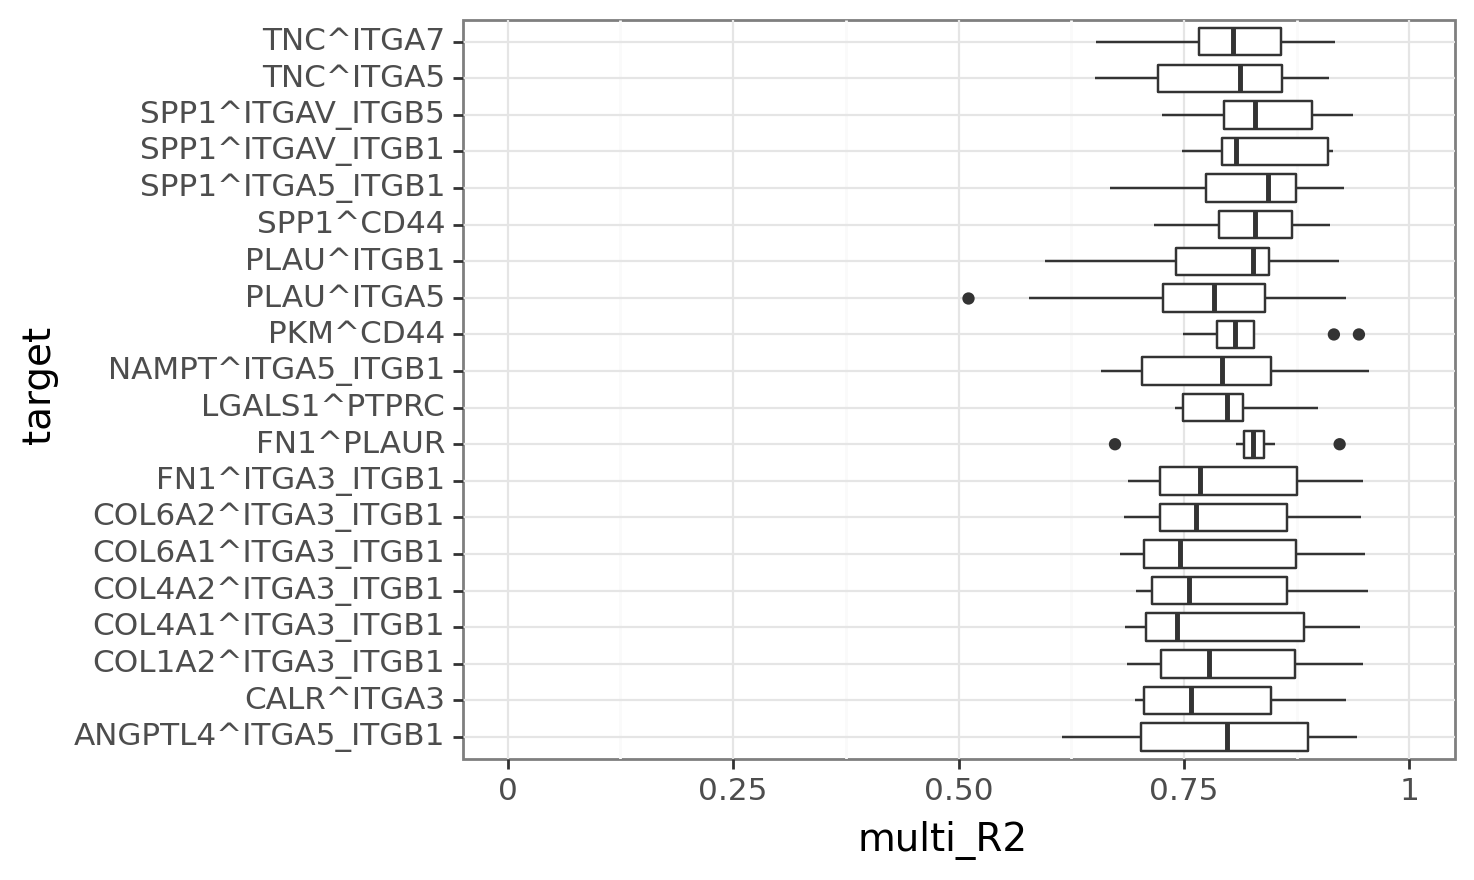

<ggplot: (8777079494536)>

In [28]:
# boxplot of y=multi_R2, x=target
(
    p9.ggplot(targets, p9.aes(x='target', y='multi_R2')) +
    p9.geom_boxplot() +
    p9.theme_bw(base_size=14) +
    # limits of y
    p9.ylim(0, 1) +
    # flip xy
    p9.coord_flip()
) 

In [29]:
targets.groupby('target').mean().sort_values('multi_R2', ascending=False).head(10)

/tmp/ipykernel_15098/3918919098.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


intra_R2  multi_R2   gain_R2      comp        tf
target                                                              
SPP1^ITGAV_ITGB5         0.0  0.839649  0.839649  0.044155  0.955845
SPP1^ITGAV_ITGB1         0.0  0.834894  0.834894  0.051469  0.948531
PKM^CD44                 0.0  0.824156  0.824156  0.057617  0.942383
FN1^PLAUR                0.0  0.820345  0.820345  0.050151  0.949849
SPP1^CD44                0.0  0.819151  0.819151  0.063177  0.936823
SPP1^ITGA5_ITGB1         0.0  0.815826  0.815826  0.048954  0.951046
TNC^ITGA7                0.0  0.802912  0.802912  0.052178  0.947822
COL1A2^ITGA3_ITGB1       0.0  0.799821  0.799821  0.059538  0.940462
FN1^ITGA3_ITGB1          0.0  0.799327  0.799327  0.062693  0.937307
LGALS1^PTPRC             0.0  0.795172  0.795172  0.057295  0.942705

## Plot Averages across slides

In [30]:
interaction = 'SPP1^ITGA5_ITGB1'

In [31]:
ints.sort_values("importances")

sample               target predictor  view  importances
6041     AKK003_157775   COL4A1^ITGA3_ITGB1        CM  comp   -52.754700
6111     AKK003_157775  ANGPTL4^ITGA5_ITGB1        CM  comp   -50.511280
6071     AKK003_157775   COL4A2^ITGA3_ITGB1        CM  comp   -49.357349
6061     AKK003_157775   COL1A2^ITGA3_ITGB1        CM  comp   -48.098866
6051     AKK003_157775      FN1^ITGA3_ITGB1        CM  comp   -47.771584
...                ...                  ...       ...   ...          ...
27851  Visium_19_CK297             PKM^CD44       Fib  comp    57.839985
21784  Visium_18_CK296            SPP1^CD44   Myeloid  comp    60.643299
39921   Visium_7_CK285           PLAU^ITGB1       Fib  comp    61.863575
21944  Visium_18_CK296            FN1^PLAUR   Myeloid  comp    64.843872
21794  Visium_18_CK296             PKM^CD44   Myeloid  comp    70.185921

[51006 rows x 5 columns]

In [32]:
### boxplot of tf view
sum_ints = ints.dropna().copy()

In [33]:
# mean and std
sum_ints = sum_ints.groupby(['target', 'view', 'predictor']).agg({'importances':['mean', 'std', 'median']}).reset_index()
# reset names
sum_ints.columns = ['target', 'view', 'predictor', 'mean', 'std', 'median']

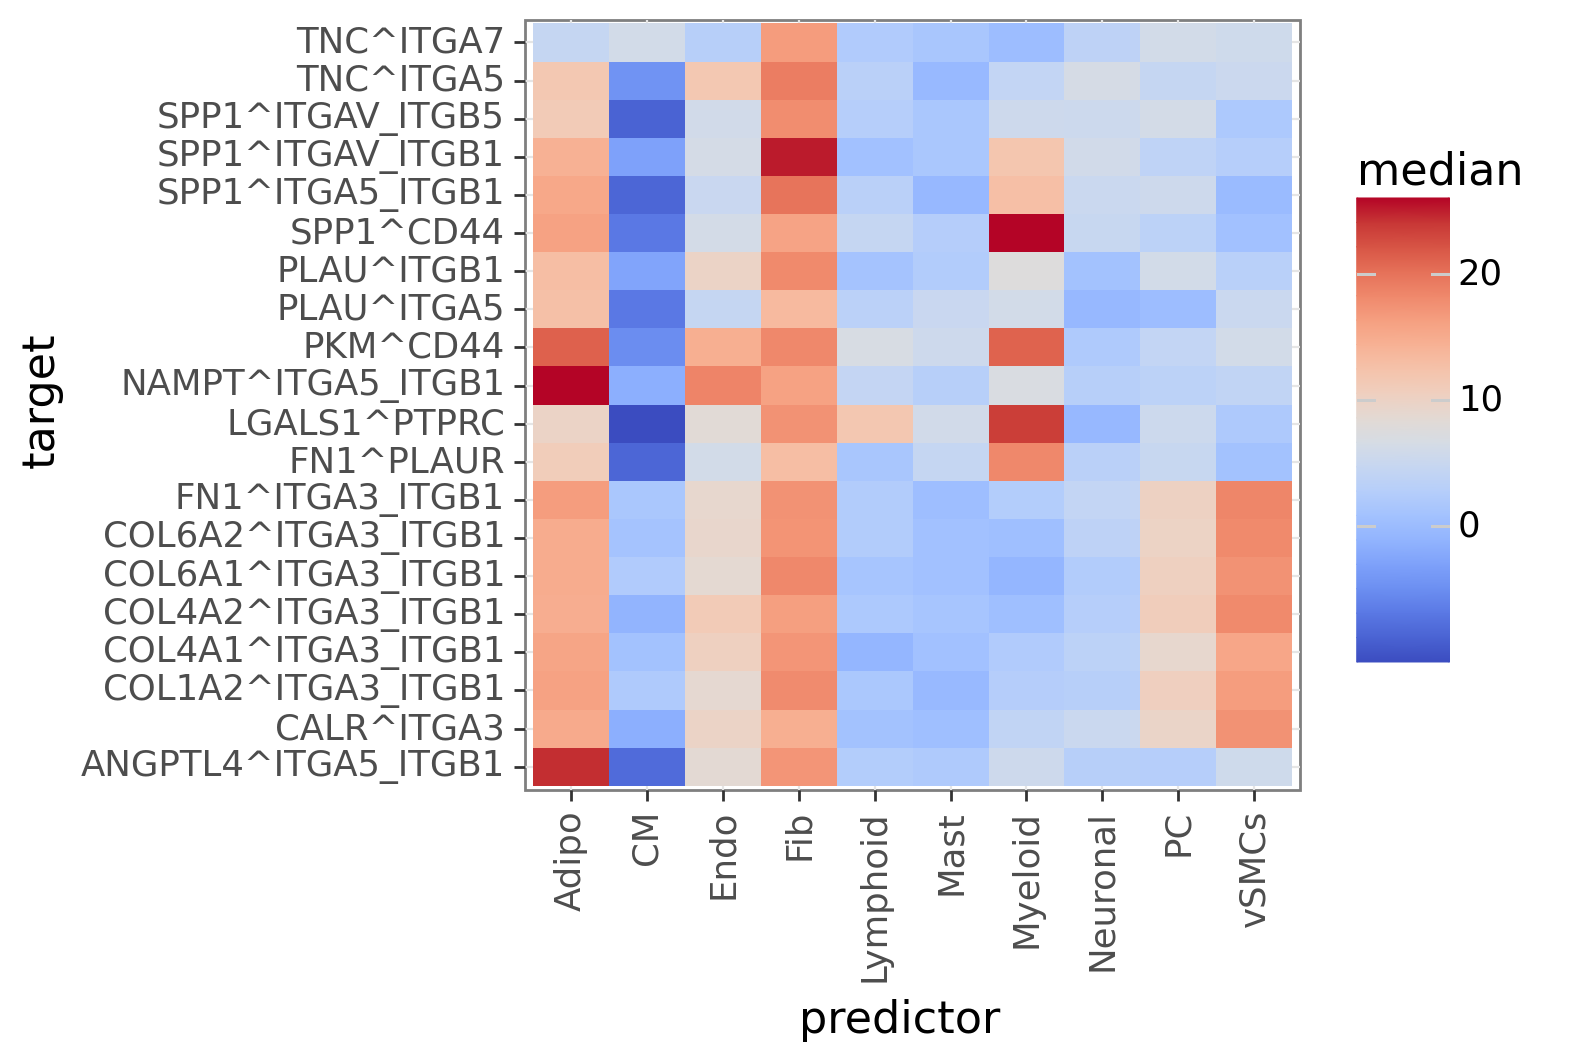

<ggplot: (8777104739046)>

In [34]:
# heatmap
(
    p9.ggplot(sum_ints[(sum_ints['view']=='comp')], p9.aes(x='predictor', y='target', fill='median')) + 
    p9.geom_tile() +
    p9.theme_bw(base_size=16) +
    p9.theme(axis_text_x=p9.element_text(angle=90)) +
    p9.scale_fill_cmap('coolwarm') +
    p9.theme(figure_size=(5, 5))
)

Top TFs

In [35]:
sum_ints['target'].unique()

array(['ANGPTL4^ITGA5_ITGB1', 'CALR^ITGA3', 'COL1A2^ITGA3_ITGB1',
       'COL4A1^ITGA3_ITGB1', 'COL4A2^ITGA3_ITGB1', 'COL6A1^ITGA3_ITGB1',
       'COL6A2^ITGA3_ITGB1', 'FN1^ITGA3_ITGB1', 'FN1^PLAUR',
       'LGALS1^PTPRC', 'NAMPT^ITGA5_ITGB1', 'PKM^CD44', 'PLAU^ITGA5',
       'PLAU^ITGB1', 'SPP1^CD44', 'SPP1^ITGA5_ITGB1', 'SPP1^ITGAV_ITGB1',
       'SPP1^ITGAV_ITGB5', 'TNC^ITGA5', 'TNC^ITGA7'], dtype=object)

In [36]:
top_predictors = sum_ints[sum_ints['target']==interaction].sort_values('median', ascending=False, key=abs)

In [37]:
top_predictors = top_predictors[top_predictors['view']=='tf'].head(25)['predictor'].unique()

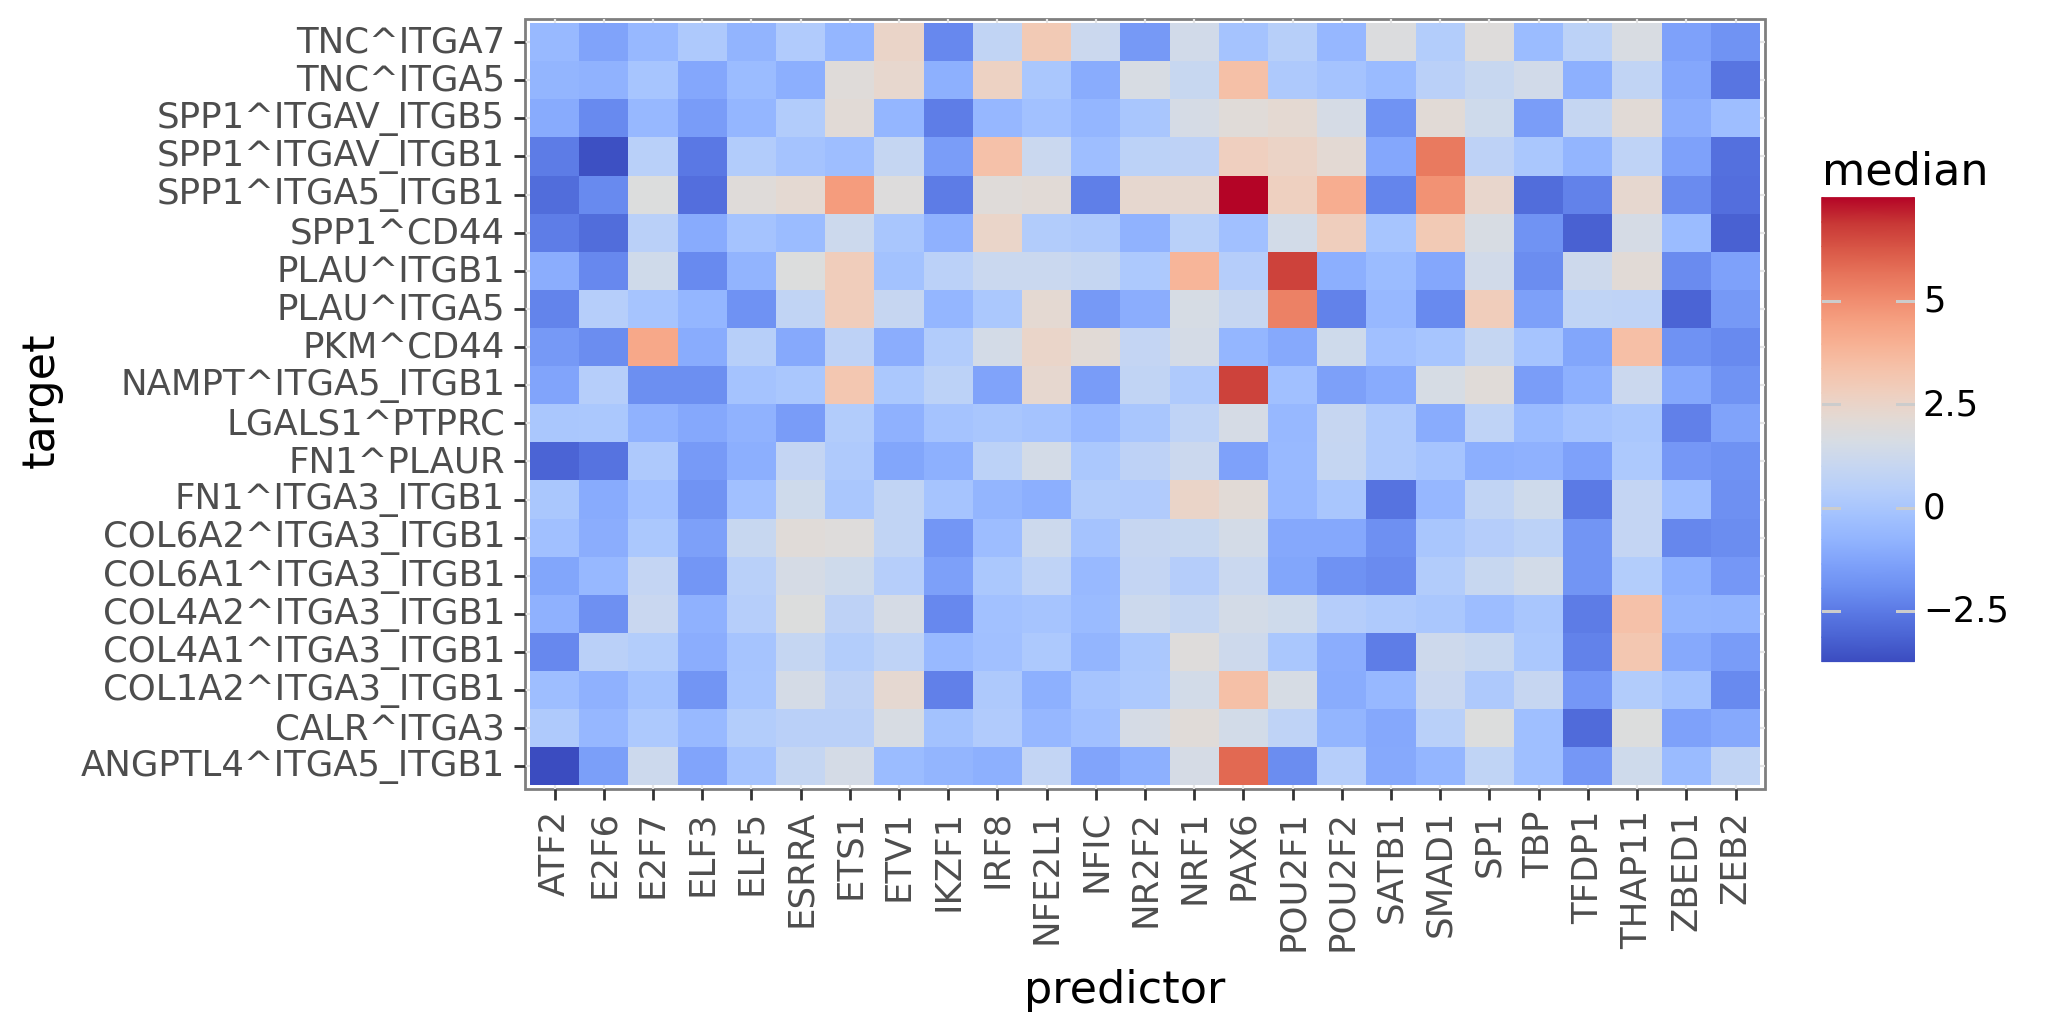

<ggplot: (8777104695284)>

In [38]:
# heatmap
(
    p9.ggplot(sum_ints[sum_ints['predictor'].isin(top_predictors)],
              p9.aes(x='predictor', y='target', fill='median')) + 
    p9.geom_tile() +
    p9.theme_bw(base_size=16) +
    p9.theme(axis_text_x=p9.element_text(angle=90)) +
    p9.scale_fill_cmap('coolwarm') +
    p9.theme(figure_size=(8, 5))
)

Boxplot of top predictors for interaction x

In [39]:
top_ints = sum_ints[sum_ints['target']==interaction].sort_values("median", key=abs, ascending=False).head(15)

In [40]:
top_predictors = top_ints['predictor'].values

In [41]:
top_ints = ints[(ints['target']==interaction) & (ints['predictor'].isin(top_predictors))].copy()

In [42]:
top_ints['predictor'] = pd.Categorical(top_ints['predictor'], categories=top_predictors, ordered=True)

In [43]:
top_ints['view'].replace({'tf': 'Regulator', 'comp': 'Cell type'}, inplace=True)

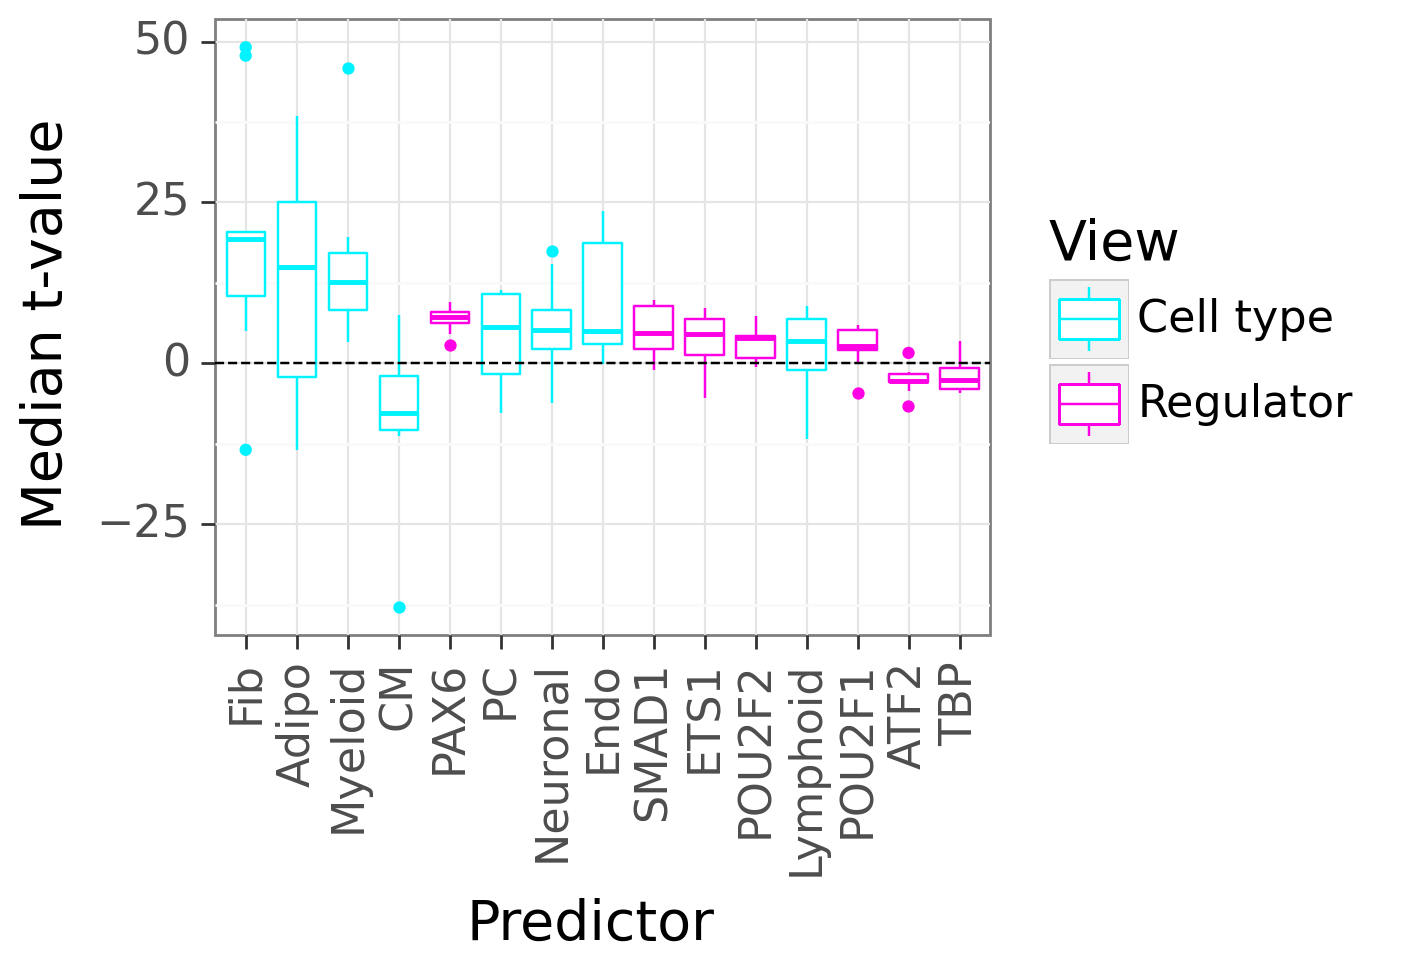

<ggplot: (8777104750160)>

In [44]:
### boxplot
(
    p9.ggplot(top_ints, p9.aes(x='predictor', y='importances', colour='view')) +
    p9.geom_boxplot() +
    p9.theme_bw(base_size = 20) +
    p9.theme(axis_text_x=p9.element_text(rotation=90), figure_size=(5, 4)) +
    # labels
    p9.labs(x='Predictor', y='Median t-value', color='View') +
    # neon palette two colours
    p9.scale_colour_manual(values=['#00F3FF', '#FF00E4']) +
    p9.geom_hline(yintercept=0, linetype='dashed', color='black')
)

In [45]:
sum_ints[sum_ints['target']==interaction].sort_values('median').tail(10)

target  view predictor       mean        std     median
4755  SPP1^ITGA5_ITGB1    tf    POU2F2   3.450057   2.746716   3.977164
4627  SPP1^ITGA5_ITGB1    tf      ETS1   3.434521   4.892868   4.504538
4783  SPP1^ITGA5_ITGB1    tf     SMAD1   4.852253   4.071565   4.742157
4562  SPP1^ITGA5_ITGB1  comp      Endo   9.994502   9.022297   5.067097
4567  SPP1^ITGA5_ITGB1  comp  Neuronal   5.688513   7.489856   5.197268
4568  SPP1^ITGA5_ITGB1  comp        PC   4.486952   7.006652   5.671780
4747  SPP1^ITGA5_ITGB1    tf      PAX6   6.838231   2.029297   7.222855
4566  SPP1^ITGA5_ITGB1  comp   Myeloid  15.604506  12.512728  12.646366
4560  SPP1^ITGA5_ITGB1  comp     Adipo  13.623975  17.269850  15.053202
4563  SPP1^ITGA5_ITGB1  comp       Fib  19.278237  19.595250  19.336481

Example Slide

In [46]:
mdatas.keys()

dict_keys(['AKK002_157779', 'AKK003_157775', 'Visium_11_CK289', 'Visium_15_CK293', 'Visium_18_CK296', 'Visium_19_CK297', 'Visium_20_CK298', 'Visium_7_CK285', 'Visium_9_CK287'])

In [47]:
slide = 'Visium_7_CK285'
comp = 'Fib'
tf = 'PAX6'
xy_sep = "<->"

In [48]:
import re

In [49]:
mdata = mdatas[slide].copy()

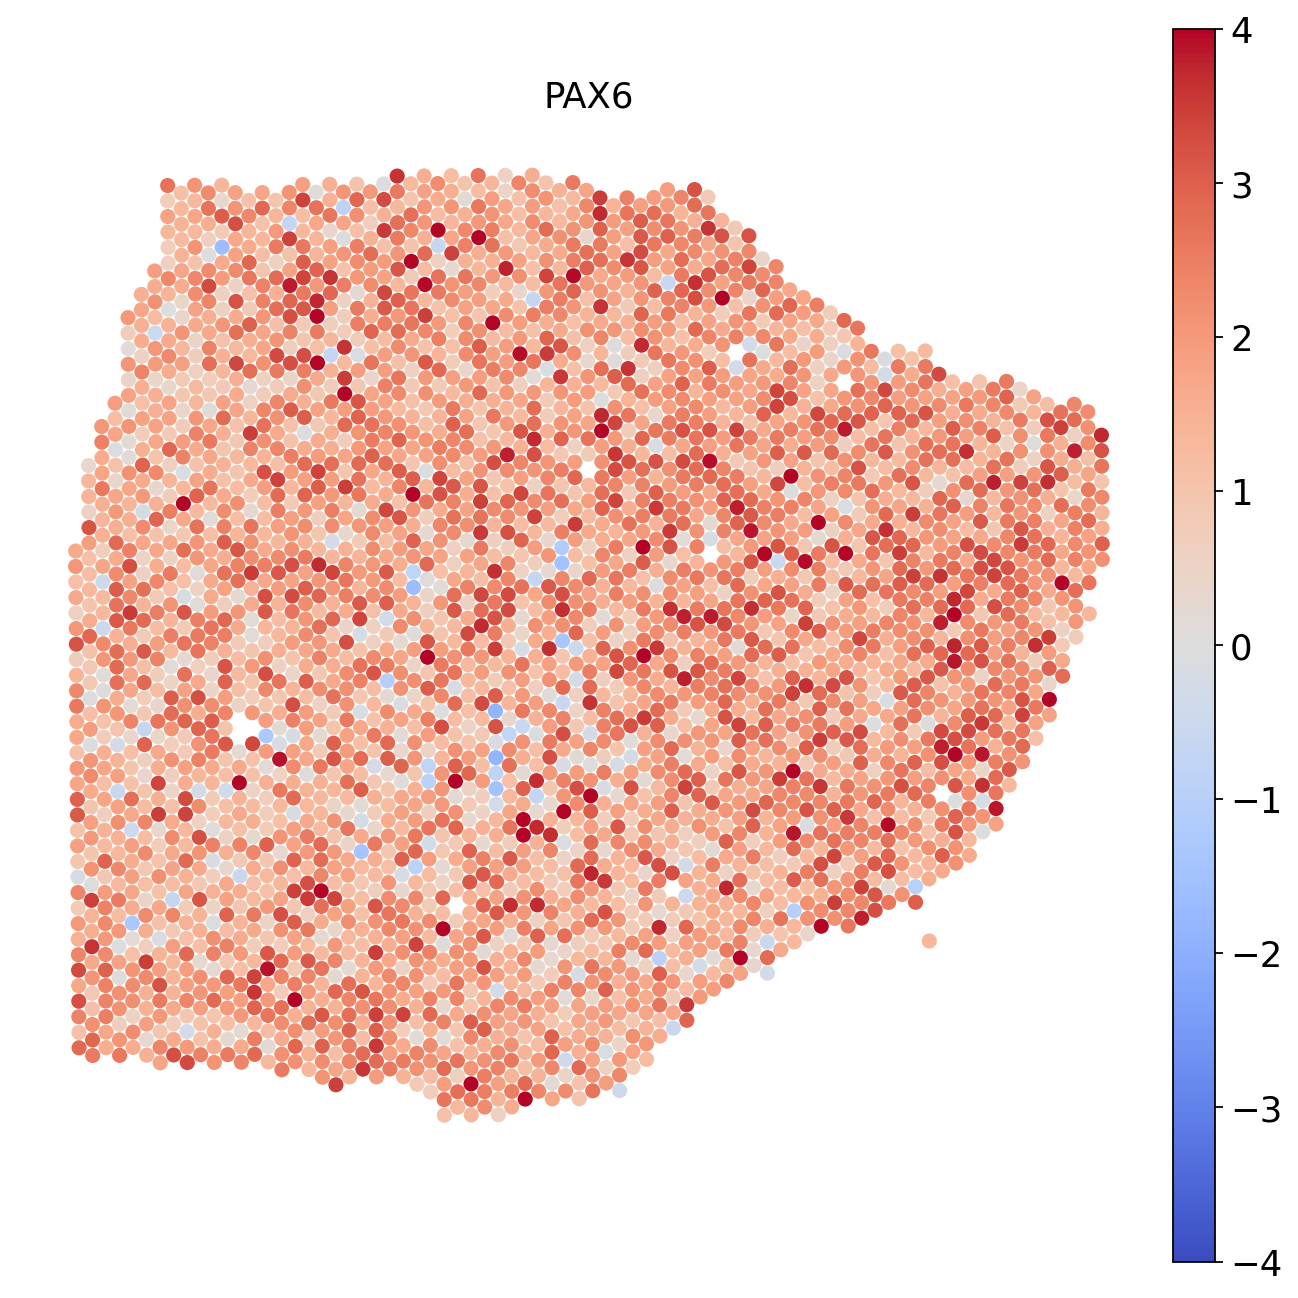

In [50]:
sq.pl.spatial_scatter(mdata.mod['tf'], color=tf, cmap="coolwarm", img=False, size=1.5, vmin=-4, vmax=4)
                      

'SPP1^ITGA5_ITGB1'

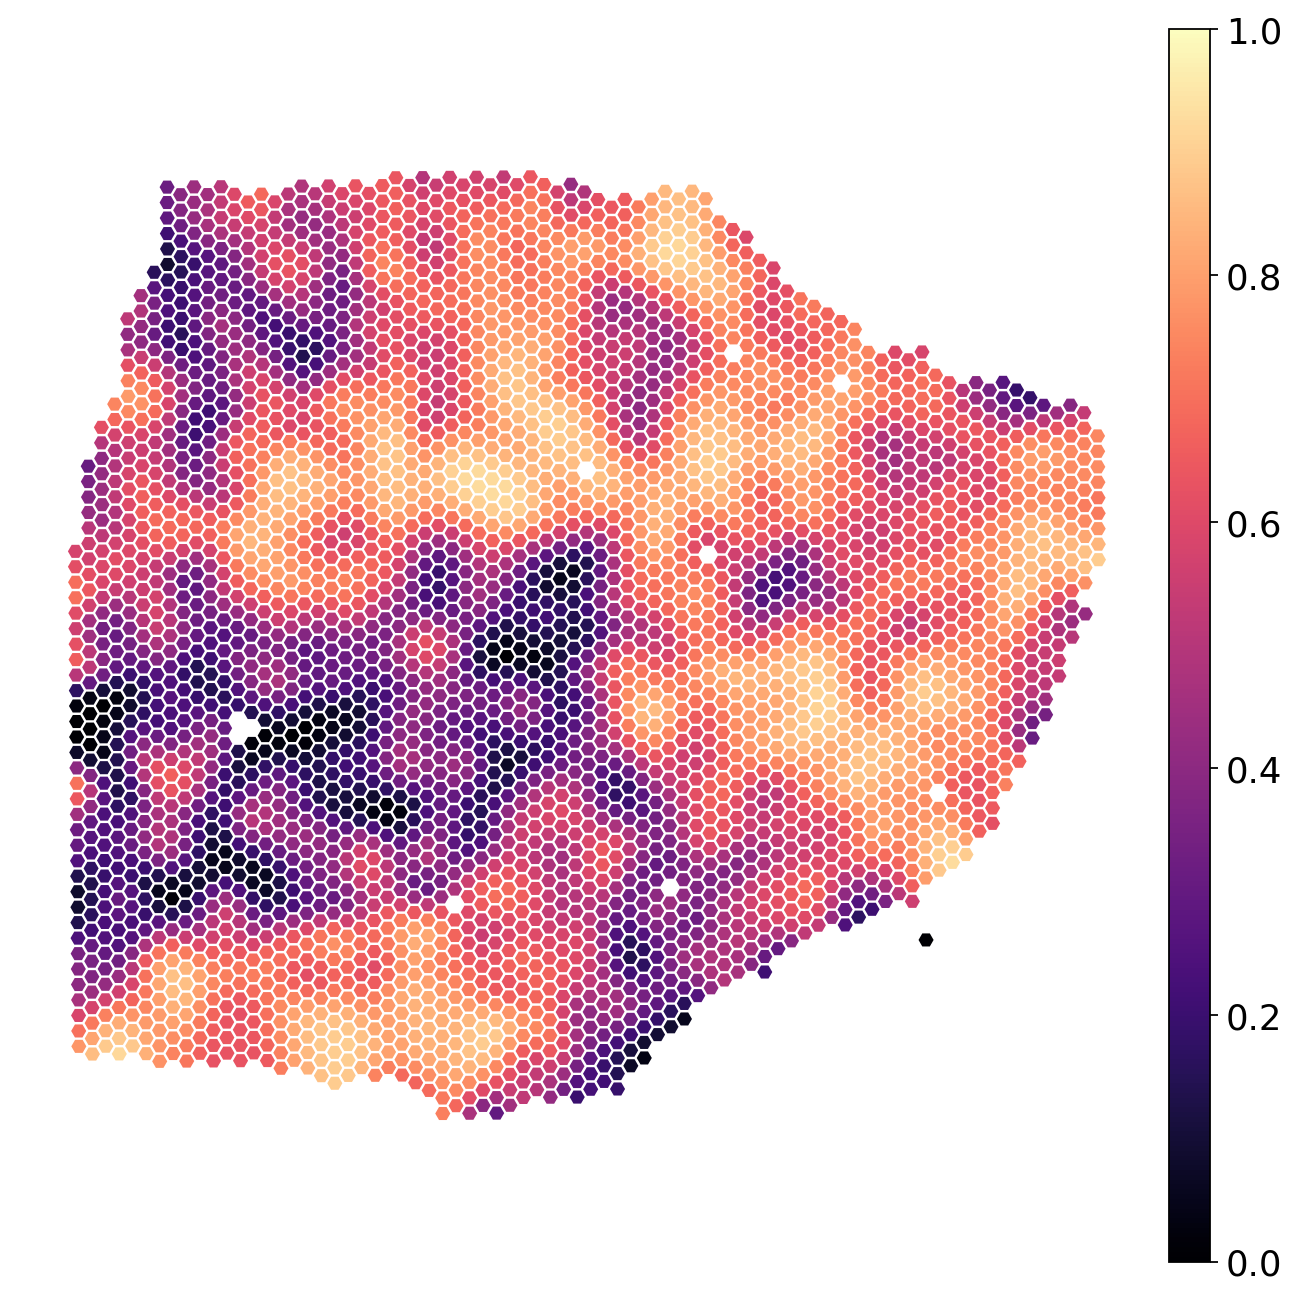

In [51]:
sq.pl.spatial_scatter(mdata.mod['intra'], color=interaction, cmap="magma", img=False, alpha=1, shape='hex', size=1.5, vmax=1, vmin=0, title="")
interaction

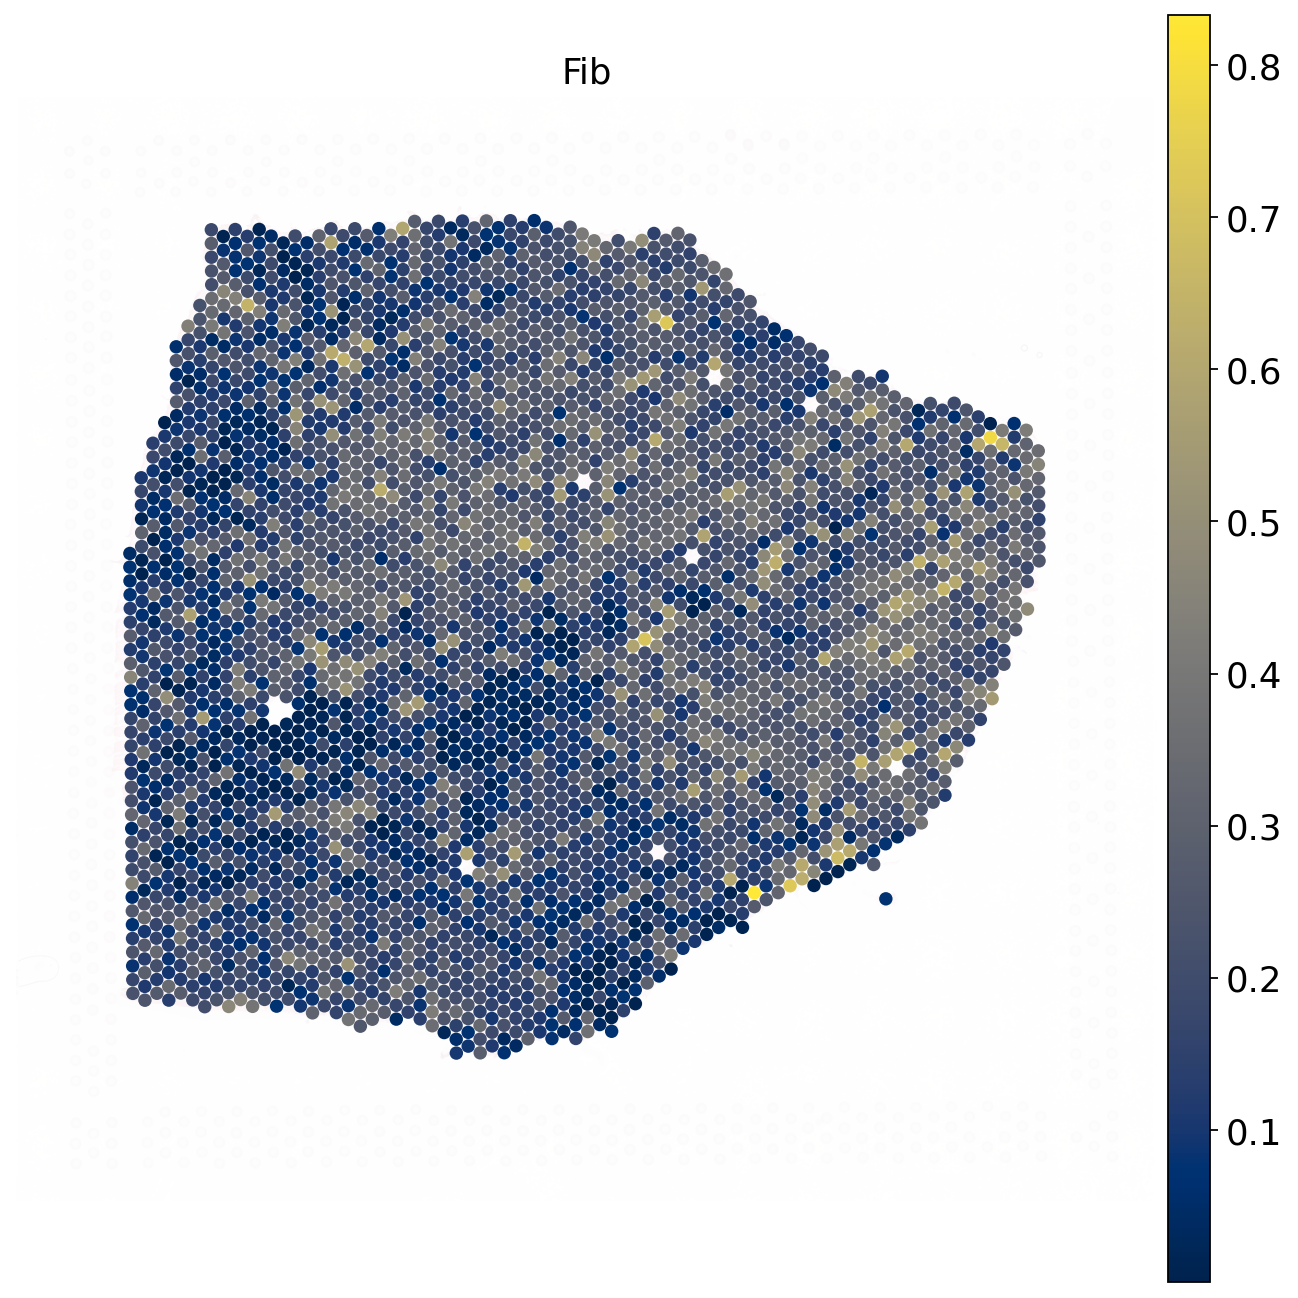

In [52]:
sq.pl.spatial_scatter(mdata.mod['comp'], color='Fib', cmap="cividis", img_alpha=0.05, size=1.5)

BASIS

In [53]:
lrdata = mdata.mod['intra'].copy()

In [54]:
mdata.obsm = lrdata.obsm.copy()
mdata.uns = lrdata.uns.copy()
mdata.obsp = lrdata.obsp.copy()

In [55]:
li.mt.bivar(mdata,
            function_name='cosine',
            x_mod='tf', y_mod='intra',
            x_transform=sc.pp.scale,
            y_transform=sc.pp.scale,
            interactions=[(tf, interaction)],
            mask_negatives=True, 
            add_categories=True,
            n_perms=100,
            complex_sep=None,
            xy_sep='<->',
            )

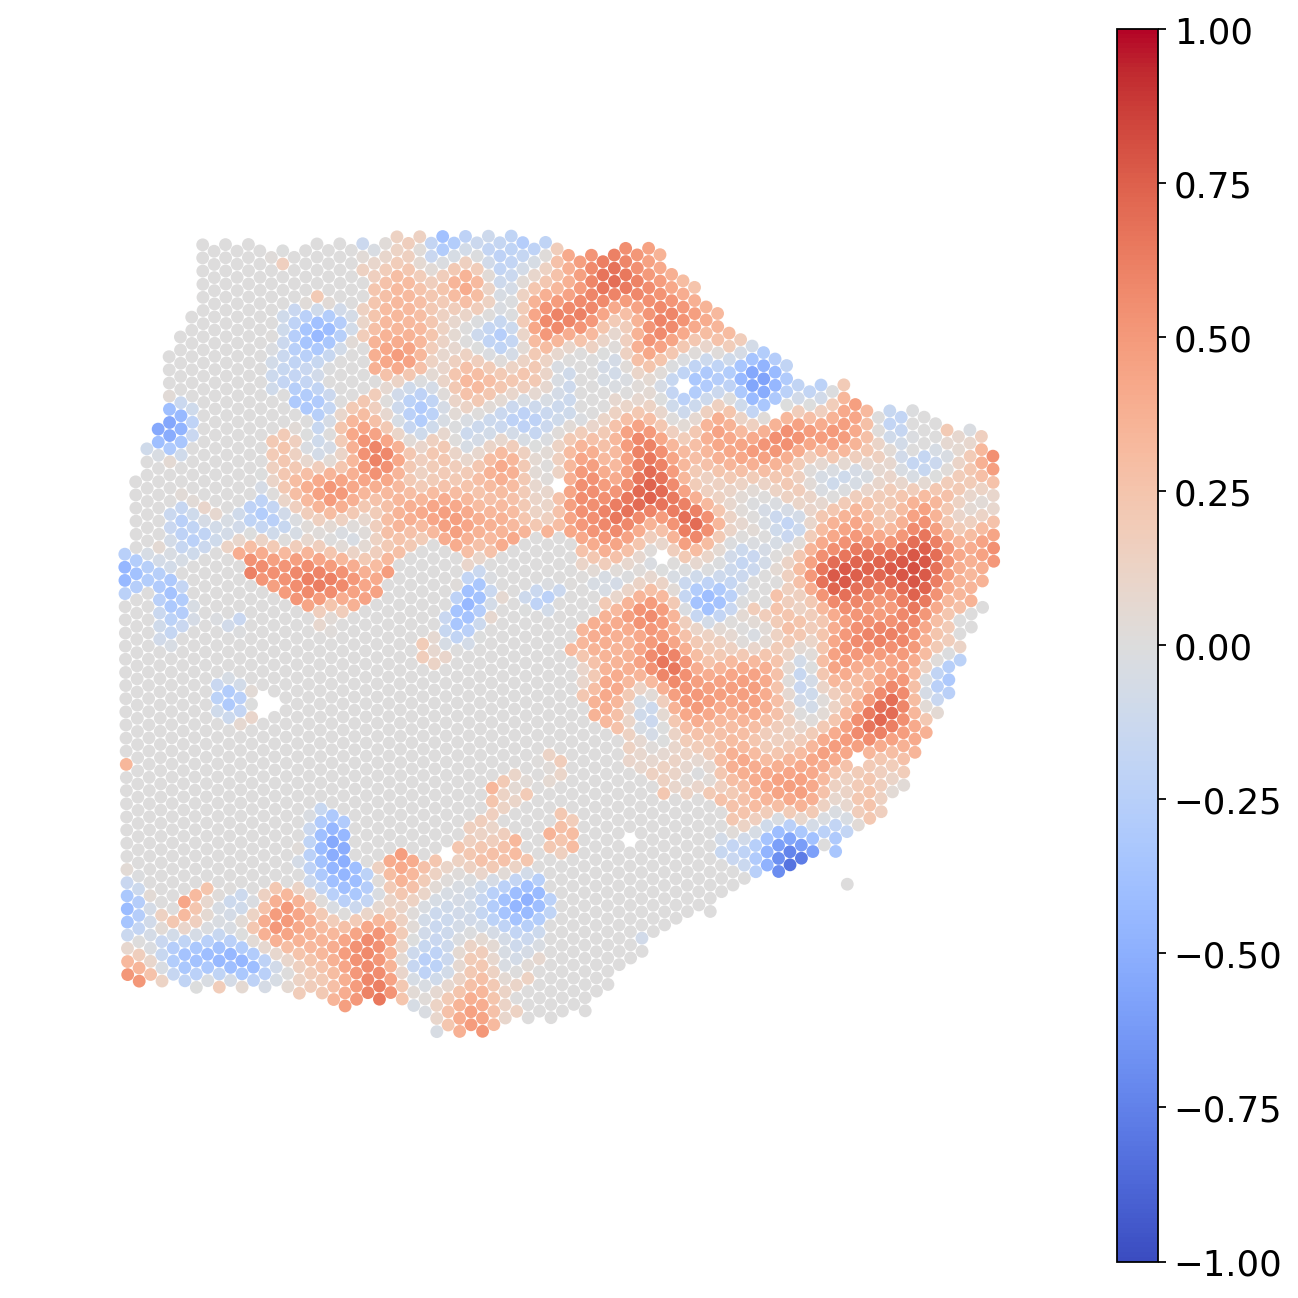

In [56]:
sq.pl.spatial_scatter(mdata.mod['local_scores'], color=f'{tf}{xy_sep}{interaction}', cmap="coolwarm", img_alpha=0, size=1.5, title="", vmin=-1, vmax=1)

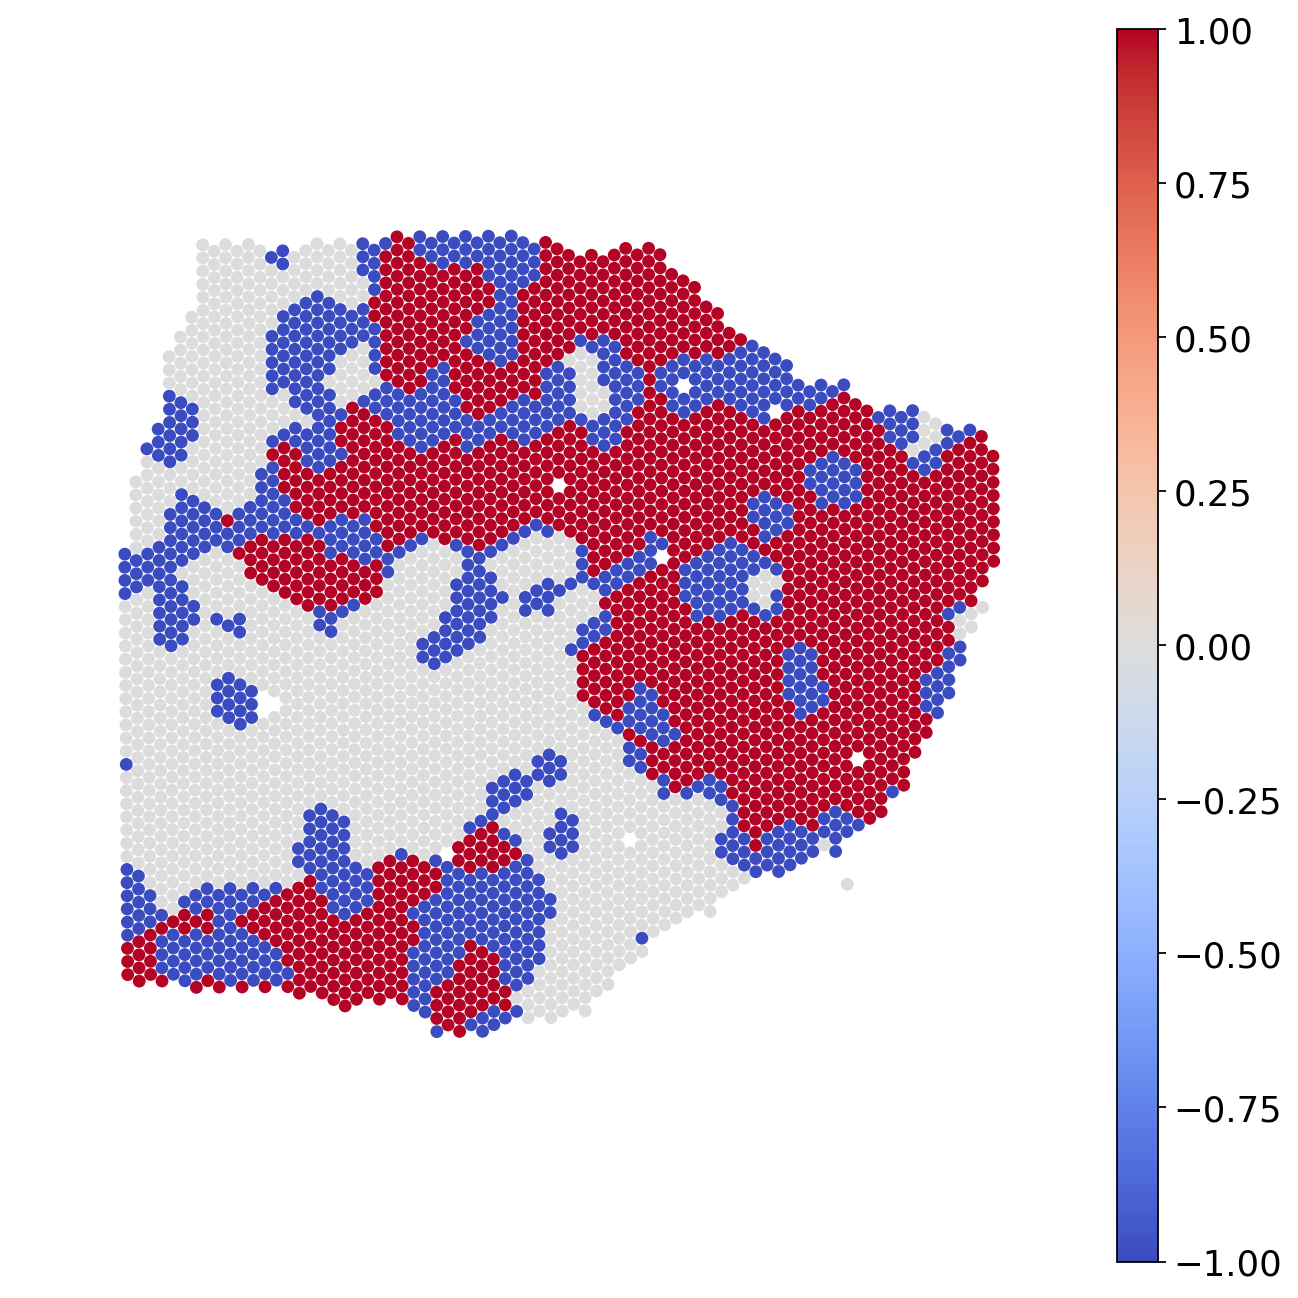

In [57]:
sq.pl.spatial_scatter(mdata.mod['local_scores'], layer='cats', color=f'{tf}{xy_sep}{interaction}', cmap="coolwarm", img_alpha=0, size=1.5, title="")

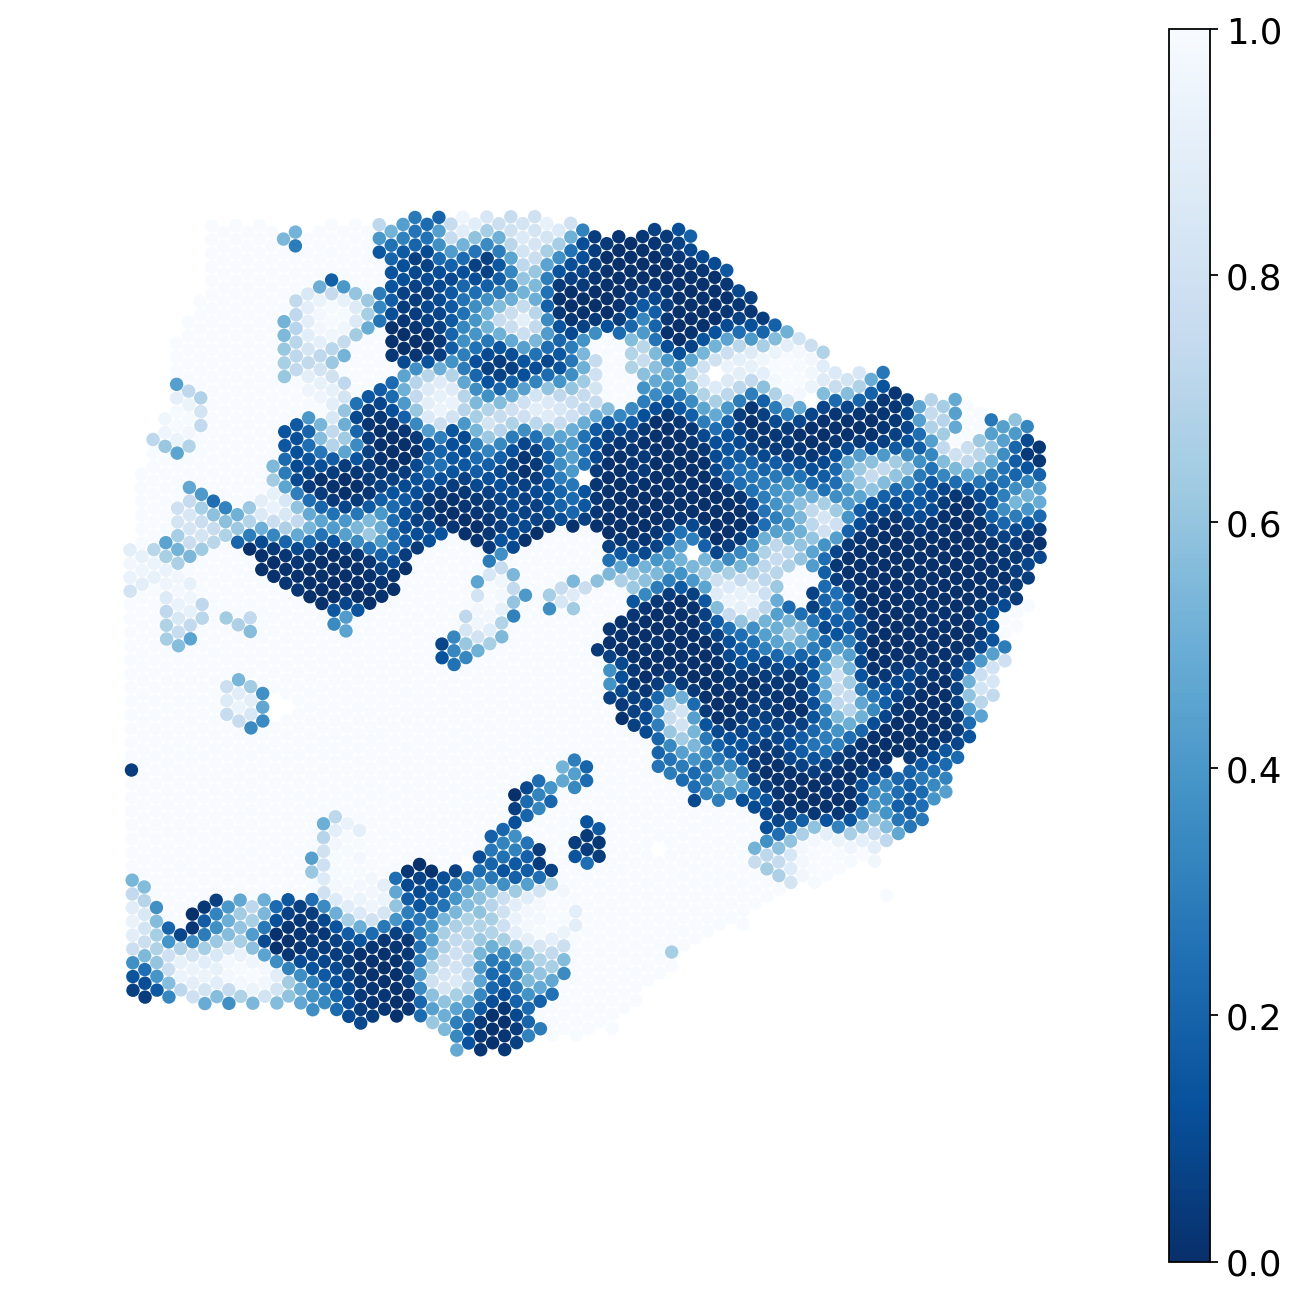

In [58]:
sq.pl.spatial_scatter(mdata.mod['local_scores'], layer='pvals', color=f'{tf}{xy_sep}{interaction}', cmap="Blues_r", img_alpha=0, size=1.5, title="")

In [59]:
nmfdata = sc.read_h5ad(os.path.join('results', 'nmf', slide+'.h5ad'))

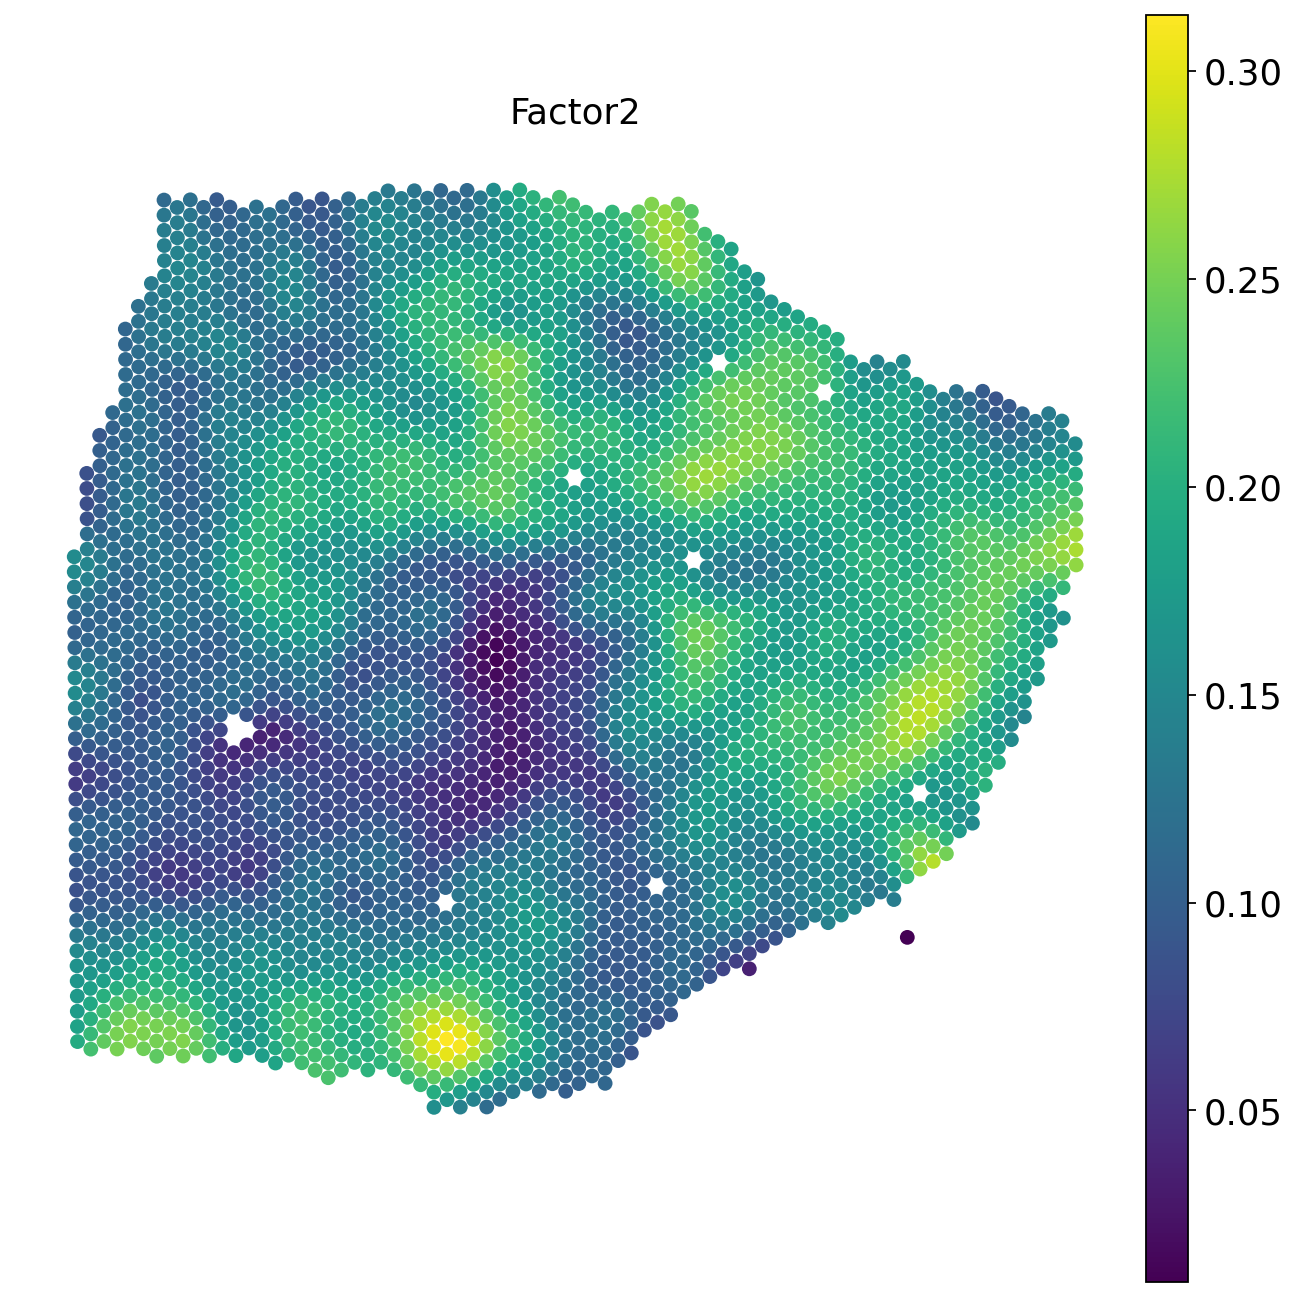

In [60]:
sq.pl.spatial_scatter(nmfdata, color=selected_factor, cmap="viridis", img=False, size=1.5)